## Air pollution forecasting

with a shifted window based on the tutorial of:https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
    

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import keras


from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [55]:
# load dataset
SAMPLING_RATE = "1H"
df = read_csv('EPD Kwun Tong.csv', header = 0)
df._time = pd.to_datetime(df._time) 
df.set_index('_time', inplace=True)
df_resampled = df.resample(SAMPLING_RATE).mean() #resamples the data by the given sampling rate
df_resampled.fillna(df_resampled.ffill(), inplace=True) # ffill: propagate last valid observation forward to next valid 
df_resampled.fillna(df_resampled.bfill(), inplace=True)  #bfill: use NEXT valid observation to fill gap
dataset = df_resampled.drop(columns=["co", "aqhi"])
#dataset = df_resampled
values = dataset.values
dataset.head(5)

,humidity,no2,o3,pm10,pm25,so2
_time,,,,,,
2018-12-15 01:00:00,68.0,24.521277,7.825,40.00,25.95,3.358779
2018-12-15 02:00:00,66.0,25.824468,9.025,45.45,25.05,3.187023
2018-12-15 03:00:00,62.0,30.478723,9.425,50.95,26.00,2.709924
2018-12-15 04:00:00,63.0,28.803191,13.975,57.90,28.45,2.500000
2018-12-15 05:00:00,60.0,20.771277,24.350,55.55,23.60,2.347328


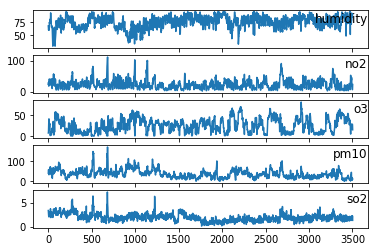

In [57]:
# specify columns to plot
groups = [0, 1, 2, 3, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [58]:
values

array([[68.        , 24.5212766 ,  7.825     , 40.        , 25.95      ,
         3.35877863],
       [66.        , 25.82446809,  9.025     , 45.45      , 25.05      ,
         3.1870229 ],
       [62.        , 30.4787234 ,  9.425     , 50.95      , 26.        ,
         2.70992366],
       ...,
       [89.        ,  7.52659574, 27.325     , 13.5       ,  8.5       ,
         2.23282443],
       [89.        , 14.46808511, 22.15      , 12.        ,  9.        ,
         2.00381679],
       [89.        , 23.67021277, 15.4       , 11.        ,  9.        ,
         1.33587786]])

In [59]:
# convert time series to supervised learning
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 	Pandas DataFrame of series framed for supervised learning.
# 	"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1] 
	df = DataFrame(data) 
	cols, names = list(), list() 
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [60]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) #WHAT DOES THAT DO????

# ensure all data is float
values = values.astype('float32')

 # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours 'We will use 3 hours of data as input.'
n_hours = 3
n_features = 7

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.593750   0.201196   0.093151   0.232463   0.578554   0.457027   
4   0.562500   0.212919   0.107763   0.264456   0.551746   0.432543   
5   0.500000   0.254785   0.112633   0.296742   0.582294   0.364533   
6   0.515625   0.239713   0.168037   0.337540   0.662095   0.334609   
7   0.468750   0.167464   0.294368   0.323745   0.499377   0.312846   

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)    ...     var3(t-1)  var4(t-1)  \
3   0.562500   0.212919   0.107763   0.264456    ...      0.112633   0.296742   
4   0.500000   0.254785   0.112633   0.296742    ...      0.168037   0.337540   
5   0.515625   0.239713   0.168037   0.337540    ...      0.294368   0.323745   
6   0.468750   0.167464   0.294368   0.323745    ...      0.383866   0.254183   
7   0.515625   0.146890   0.383866   0.254183    ...      0.457534   0.226886   

   var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
3   0.582

In [61]:
num_data = len(dataset['o3'])
num_data

3504

In [62]:
# split into train and test sets
values = reframed.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [63]:
# split into input and outputs
n_obs = n_hours * n_features

train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(2000, 21) 2000 (2000,)


In [64]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 3, 7) (2000,) (1501, 3, 7) (1501,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1501 samples
Epoch 1/20
 - 1s - loss: 0.1533 - val_loss: 0.0798
Epoch 2/20
 - 0s - loss: 0.0833 - val_loss: 0.0583
Epoch 3/20
 - 0s - loss: 0.0873 - val_loss: 0.0566
Epoch 4/20
 - 0s - loss: 0.0834 - val_loss: 0.0547
Epoch 5/20
 - 0s - loss: 0.0802 - val_loss: 0.0528
Epoch 6/20
 - 0s - loss: 0.0773 - val_loss: 0.0509
Epoch 7/20
 - 0s - loss: 0.0746 - val_loss: 0.0494
Epoch 8/20
 - 0s - loss: 0.0716 - val_loss: 0.0477
Epoch 9/20
 - 0s - loss: 0.0684 - val_loss: 0.0461
Epoch 10/20
 - 0s - loss: 0.0651 - val_loss: 0.0448
Epoch 11/20
 - 0s - loss: 0.0613 - val_loss: 0.0446
Epoch 12/20
 - 0s - loss: 0.0576 - val_loss: 0.0467
Epoch 13/20
 - 0s - loss: 0.0507 - val_loss: 0.0453
Epoch 14/20
 - 0s - loss: 0.0452 - val_loss: 0.0382
Epoch 15/20
 - 0s - loss: 0.0387 - val_loss: 0.0312
Epoch 16/20
 - 0s - loss: 0.0350 - val_loss: 0.0332
Epoch 17/

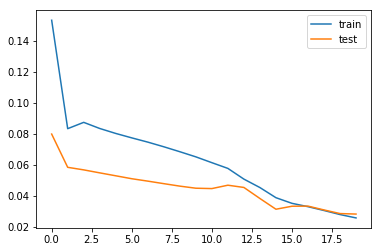

In [65]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [68]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (1501, 21)

In [67]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (1501,8) (6,) (1501,8) 